## Initialisation

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import itertools
import time
import gc

from pathlib import Path
import sys
ROOT = Path().resolve().parent
sys.path.append(str(ROOT))

from src.fsp_ms.config import Config

In [2]:
config = Config()

# Main dataset
sales = pd.read_parquet(config.get('cleaned_parquet'))

# Data-Dicts
items = pd.read_csv(config.get('items'))
items_categories = pd.read_csv(config.get('item_categories'))
shops = pd.read_csv(config.get('shops'))

# Folder - Sumbission data 
submission = pd.read_csv(config.get('submission'))
# a sample submission file in the correct format.

test = pd.read_csv(config.get('test')) 
# the test set. You need to forecast the sales 
# for these shops and products for November 2015.


In [3]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [4]:
submission

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [5]:
sales.head(50)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,was_item_price_outlier,was_item_cnt_day_outlier
0,2013-01-01,0,2,991,99.0,1.0,0,0
1,2013-01-01,0,2,1472,2599.0,1.0,0,0
2,2013-01-01,0,2,1905,249.0,1.0,0,0
3,2013-01-01,0,2,2920,599.0,2.0,0,0
4,2013-01-01,0,2,3320,1999.0,1.0,0,0
5,2013-01-01,0,2,4464,599.0,1.0,0,0
6,2013-01-01,0,2,4724,1399.0,1.0,0,0
7,2013-01-01,0,2,5649,2190.0,1.0,0,0
8,2013-01-01,0,2,6911,599.0,1.0,0,0
9,2013-01-01,0,2,6916,999.5,1.0,0,0


# DQC & ETL

## Feature  dTypes and simple statistics

In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928069 entries, 0 to 2928068
Data columns (total 8 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   date_block_num            int64         
 2   shop_id                   int64         
 3   item_id                   int64         
 4   item_price                float64       
 5   item_cnt_day              float64       
 6   was_item_price_outlier    int8          
 7   was_item_cnt_day_outlier  int8          
dtypes: datetime64[ns](1), float64(2), int64(3), int8(2)
memory usage: 139.6 MB


In [7]:
sales['date'] = pd.to_datetime(sales['date'], format='%d.%m.%Y')
# sales_sorted = sales.sort_values('date')

In [8]:
with pd.option_context('display.float_format', '{:.1f}'.format):
    print(sales[['item_price','item_cnt_day']].describe())

       item_price  item_cnt_day
count   2928069.0     2928069.0
mean        803.9           1.2
std         958.2           0.6
min           0.1           1.0
25%         249.0           1.0
50%         399.0           1.0
75%         999.0           1.0
max        5999.0           5.0


## Missing values

In [9]:
sales.isnull().sum()

date                        0
date_block_num              0
shop_id                     0
item_id                     0
item_price                  0
item_cnt_day                0
was_item_price_outlier      0
was_item_cnt_day_outlier    0
dtype: int64

## Duplicates

In [10]:
sales.duplicated().sum()

0

In [11]:
sales[sales.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,was_item_price_outlier,was_item_cnt_day_outlier


Those duplicates should be removed, there small amount of them, but all of them are clearly missing structure which data table provides on the first place. Bc item_cnt_day should represent number of products sold for exact type of product, it's supposed to be agregated feature and cannot be duplicated. Also all of duplicated pares have the same price. 

In [12]:
sales = sales.drop_duplicates().reset_index(drop=True)

## Inconsistencies

### Dicts values check

 Are all of the porvided id's are described in dicts ?

In [13]:
print('Amount of item_category_id in items which are not listed in items_categories: ',\
       items['item_category_id'].isin(items_categories['item_category_id']).sum() - items['item_category_id'].shape[0])

Amount of item_category_id in items which are not listed in items_categories:  0


In [14]:
print('Amount of item_id in main dataset which are not listed in items dicts: ' ,\
      sales['item_id'].isin(items['item_id']).sum() - sales.shape[0])

Amount of item_id in main dataset which are not listed in items dicts:  0


In [15]:
print('Amount of shop_id in main dataset which are not listed in shops dict: ' ,\
       sales['shop_id'].isin(shops['shop_id']).sum() - sales.shape[0])

Amount of shop_id in main dataset which are not listed in shops dict:  0


In [16]:
print('Amount of shop_id in main dataset which are not listed in shops dict: ' ,\
      test['shop_id'].isin(shops['shop_id']).sum() - test.shape[0])

Amount of shop_id in main dataset which are not listed in shops dict:  0


In [17]:
print('Amount of item_id in test dataset which are not listed in items dicts: ' ,\
      test['item_id'].isin(items['item_id']).sum() - test.shape[0])

Amount of item_id in test dataset which are not listed in items dicts:  0


Checking shops dictionary:

In [18]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


shop_id's which duplicates each other :
 - 10 and 11 are the same
 - 1 and 58
 - 0 and 57
 - 40 and 39
 - 23 and 24

In [19]:
shop_id_replacements = {10: 11, 1: 58, 0: 57, 40: 39}

In [20]:
# test[test['shop_id'].isin(shop_id_replacements.keys())]['shop_id'].value_counts()

In [21]:
for old_id, new_id in shop_id_replacements.items():
    if old_id in test['shop_id'].values and new_id in test['shop_id'].values:
        print(f'⚠️ Shops {old_id} and {new_id} duplicates each other in test')
    else:
        print(f'No simultaneous presence of {old_id} shop_id and {new_id} in test')

No simultaneous presence of 10 shop_id and 11 in test
No simultaneous presence of 1 shop_id and 58 in test
No simultaneous presence of 0 shop_id and 57 in test
No simultaneous presence of 40 shop_id and 39 in test


In [22]:
sales['shop_id'] = sales['shop_id'].replace(shop_id_replacements)
test['shop_id'] = test['shop_id'].replace(shop_id_replacements)

Since we now clearly know that we have some duplicates in shops, we should summ item_cnt_day for them

In [23]:
print('Amount of duplicates after dicts replacement : ', sales.duplicated().sum())
sales_sorted = sales.sort_values('date')
sales_sorted[(sales_sorted.duplicated(keep= False))].head(50)

Amount of duplicates after dicts replacement :  0


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,was_item_price_outlier,was_item_cnt_day_outlier


In [24]:
sales = sales.groupby(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price'], as_index=False).agg({'item_cnt_day': 'sum'})
print('Amount of duplicates after grouping : ', sales.duplicated().sum())

Amount of duplicates after grouping :  0


### Adding shops, items, and categories names

Based on dictionaries values of shops, items, and categories. It would be good to add some additional categories with grouping categories_names by their type, and shops by cities. 

In [25]:
items_categories[0:50]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [26]:
items_categories['general_item_category_name'] = items_categories['item_category_name'].\
    apply(lambda x: 'Игровые консоли' if x.split()[0] == 'Игровые' else x.split()[0] )

In [27]:
items_categories[0:50]

,item_category_name,item_category_id,general_item_category_name
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
5,Аксессуары - PSVita,5,Аксессуары
6,Аксессуары - XBOX 360,6,Аксессуары
7,Аксессуары - XBOX ONE,7,Аксессуары
8,Билеты (Цифра),8,Билеты
9,Доставка товара,9,Доставка


The same idea is better to apply to cities of shops

In [28]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [29]:
shops['city'] = shops['shop_name'].apply(lambda x: 'Якутск' if x.split()[0] == '!Якутск' else x.split()[0] )

In [30]:
sales = sales.merge(items, on='item_id', how='left')
sales = sales.merge(items_categories, on = 'item_category_id', how = 'left')
sales = sales.merge(shops, on = 'shop_id', how = 'left')

In [31]:
sales.sample(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,general_item_category_name,shop_name,city
1276633,2014-01-03,12,50,7882,1390.0,1.0,X360: Super ZOOM [только для Kinect],6,Аксессуары - XBOX 360,Аксессуары,"Тюмень ТЦ ""Гудвин""",Тюмень
1125666,2013-12-02,11,6,12356,349.0,1.0,КАК ПОЙМАТЬ ПЕРО ЖАР ПТИЦЫ,40,Кино - DVD,Кино,"Воронеж (Плехановская, 13)",Воронеж
1321871,2014-01-17,12,17,15741,299.0,1.0,НИКТО НЕ ВЫЖИЛ (BD),37,Кино - Blu-Ray,Кино,"Красноярск ТЦ ""Взлетка Плаза""",Красноярск
703140,2013-07-23,6,37,6433,449.0,1.0,Sid Meier's Civilization V. Дивный новый мир (...,28,Игры PC - Дополнительные издания,Игры,"Новосибирск ТЦ ""Мега""",Новосибирск
2149149,2014-11-18,22,6,16671,299.0,1.0,ОТВЕРЖЕННЫЕ (BD),37,Кино - Blu-Ray,Кино,"Воронеж (Плехановская, 13)",Воронеж
98083,2013-01-26,0,32,19811,349.0,2.0,ТРИ БОГАТЫРЯ НА ДАЛЬНИХ БЕРЕГАХ,40,Кино - DVD,Кино,"Москва ТЦ ""Серебряный Дом""",Москва
2066674,2014-10-17,21,55,1845,299.0,1.0,"Battlefield 3: End Game [PC, Цифровая версия]",31,Игры PC - Цифра,Игры,Цифровой склад 1С-Онлайн,Цифровой
1990049,2014-09-18,20,25,3043,1799.0,1.0,"Dragon's Crown [PS Vita, английская версия]",22,Игры - PSVita,Игры,"Москва ТРК ""Атриум""",Москва
2257014,2014-12-22,23,7,6185,499.0,1.0,"S.T.A.L.K.E.R.: Зов Припяти [PC, Jewel, русска...",30,Игры PC - Стандартные издания,Игры,"Воронеж ТРЦ ""Максимир""",Воронеж
1238036,2013-12-28,11,58,10487,399.0,1.0,ГОРЬКО!,40,Кино - DVD,Кино,"Якутск ТЦ ""Центральный""",Якутск


## Outliers

### Item prices

In [32]:
sales.shape[0]

2928069

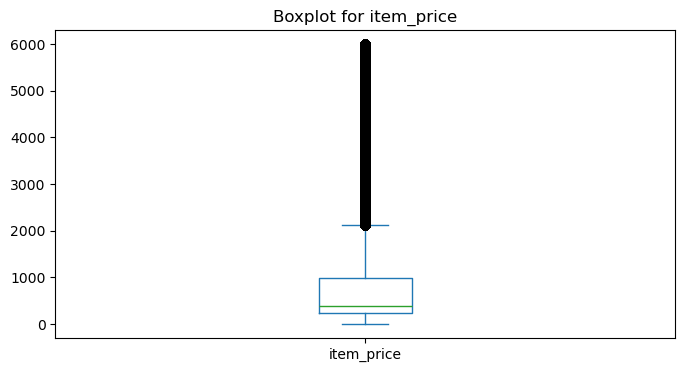

In [33]:
plt.figure(figsize=(8, 4))
sales['item_price'].plot.box()
plt.title('Boxplot for item_price')
plt.show()

Quatniles estimation:

In [34]:
item_price_q99 = sales['item_price'].quantile(0.99)
item_price_q01 = sales['item_price'].quantile(0.01)
print('quantile 99:', item_price_q99 )
print('item_price amount of observations higher than q99:',sales[sales['item_price']>item_price_q99]['item_id'].count())
print('-'*20)
print('quantile 01:',item_price_q01)
print('item_price amount of observations lower than q01:',sales[sales['item_price']<item_price_q01]['item_id'].count())

quantile 99: 5999.0
item_price amount of observations higher than q99: 0
--------------------
quantile 01: 5.0
item_price amount of observations lower than q01: 6314


In [35]:
sales[sales['item_price'] >item_price_q99]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,general_item_category_name,shop_name,city


In [36]:
print( sales[sales['item_price']<=0] ) # Observations with negative or zero price
sales = sales[sales['item_price'] > 0] # Assigning only positive price

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day, item_name, item_category_id, item_category_name, general_item_category_name, shop_name, city]
Index: []


As we can see, there a lot outliers there, and we cannot remove them, since we might remove some expensive categories entirely. We will use .clip() to round outliers to feasible values but will save data about prices outliers

In [37]:
sales['was_item_price_outlier'] = ( sales['item_price'] > item_price_q99 ).astype('int8')

In [38]:
sales['item_price'] = sales['item_price'].clip(0,item_price_q99)
sales.shape[0]

2928069

After Clipping: 

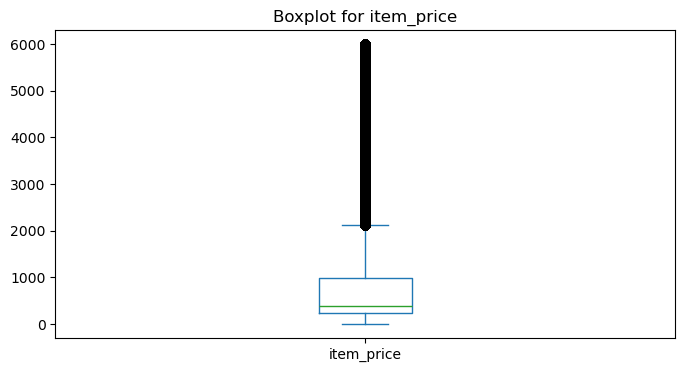

In [39]:
plt.figure(figsize=(8, 4))
sales['item_price'].plot.box()
plt.title('Boxplot for item_price')
plt.show()

Negative prices removed, outlier from higher bound are tagged and rounded to lower values

### Amount of items sold in a day, in a single shop

Let's check another quantative feature - amount of sold exact items_id by a single day

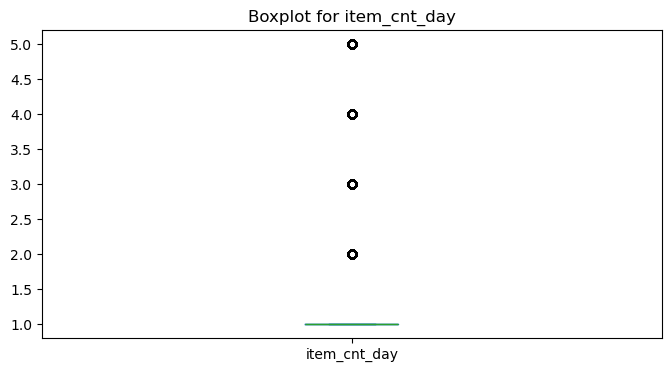

In [40]:
plt.figure(figsize=(8, 4))
sales['item_cnt_day'].plot.box()
plt.title('Boxplot for item_cnt_day')
plt.show()

From first glance on the main dataset also noted that item_cnt_day has some negative values, let's check it and do a quantile estimation:

In [41]:
item_cnt_day_q99 = sales['item_cnt_day'].quantile(0.99)
item_cnt_day_q01 = sales['item_cnt_day'].quantile(0.01)
print('quantile 99:', item_cnt_day_q99 )
print('item_cnt_day amount of observations higher than q99:', sales[sales['item_cnt_day']>item_cnt_day_q99]['item_id'].count())
print('-'*20)
print('quantile 01:',item_cnt_day_q01)
print('item_cnt_day amount of observations lower than q01:', sales[sales['item_cnt_day']<item_cnt_day_q01]['item_id'].count())

print('-'*20)
print('Amount of items listed as sold in amount of zero : ', sales[sales['item_cnt_day'] == 0]['item_cnt_day'].count()) 
print('Amount of unique items_id listed as sold in a negative amount: ', sales[sales['item_cnt_day']<0]['item_id'].nunique())

quantile 99: 5.0
item_cnt_day amount of observations higher than q99: 0
--------------------
quantile 01: 1.0
item_cnt_day amount of observations lower than q01: 0
--------------------
Amount of items listed as sold in amount of zero :  0
Amount of unique items_id listed as sold in a negative amount:  0


In [42]:
sales[sales['item_cnt_day']>100].head(50) 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,general_item_category_name,shop_name,city,was_item_price_outlier


Let's calculate how big part of returned items, out of all sold items overall

negative_sold_amount_sum:  0.0
positive_sold_amount_sum:  3427709.0
Percentage of returns comapre to all sold items: -0.00%


<Axes: >

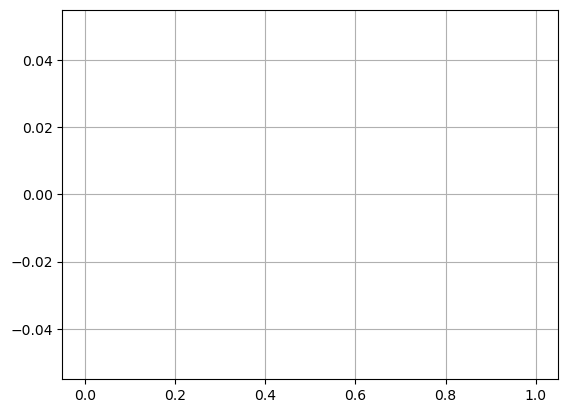

In [43]:
negative_sold_amount_sum = sales[sales['item_cnt_day']<0]['item_cnt_day'].sum() # sum of all returned back items
print('negative_sold_amount_sum: ', negative_sold_amount_sum)
positive_sold_amount_sum = sales[sales['item_cnt_day']>0]['item_cnt_day'].sum() # sum of all sold items 
print('positive_sold_amount_sum: ', positive_sold_amount_sum)
n_vs_p = negative_sold_amount_sum / positive_sold_amount_sum *100 *(-1)
print(f'Percentage of returns comapre to all sold items: {n_vs_p:.2f}%')
sales[sales['item_cnt_day'] < 0]['item_cnt_day'].hist()

As we can see amount of returns are too low (0.21%) to keep them in our main dataset. Maybe we will come back to it later, if we will discover this feature might be usefull. Removing negative values of intem_cnt_day :

In [44]:
with_negatives_sold = sales.shape[0]
sales = sales[sales['item_cnt_day'] > 0]
without_negatives_sold = sales.shape[0]
print('Amount of items before removing those with negative sales:',with_negatives_sold)
print('Amount of items after removing items with negative sales:',without_negatives_sold)
print('Removed Obeservation where items with negative sold amount by day :',with_negatives_sold-without_negatives_sold)
# sales['item_cnt_day'] = sales['item_cnt_day'].clip(0,500)

Amount of items before removing those with negative sales: 2928069
Amount of items after removing items with negative sales: 2928069
Removed Obeservation where items with negative sold amount by day : 0


Also it's worth to clip outlying high values. But before let's check what are they

In [45]:
sales[sales['item_cnt_day']>100][:50] # ⚠️⚠️⚠️ Before applying - run "Adding shops, items, and categories names block" to see explicit data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,general_item_category_name,shop_name,city,was_item_price_outlier


Seems all of them are games related to day of releas of several top games, which is a rare event, we will cut off amount of them sold and create a feature "was_item_cnt_day_outlier". 

In [46]:
sales['was_item_cnt_day_outlier'] = ( sales['item_cnt_day'] >  item_cnt_day_q99 ).astype(np.int8)

In [47]:
sales['item_cnt_day'] = sales['item_cnt_day'].clip(0,item_cnt_day_q99)

"Returns" are removed, outliers with higher bound are tagged and rounded to 99th quantile value. 

In [48]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928069 entries, 0 to 2928068
Data columns (total 14 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   date                        datetime64[ns]
 1   date_block_num              int64         
 2   shop_id                     int64         
 3   item_id                     int64         
 4   item_price                  float64       
 5   item_cnt_day                float64       
 6   item_name                   object        
 7   item_category_id            int64         
 8   item_category_name          object        
 9   general_item_category_name  object        
 10  shop_name                   object        
 11  city                        object        
 12  was_item_price_outlier      int8          
 13  was_item_cnt_day_outlier    int8          
dtypes: datetime64[ns](1), float64(2), int64(4), int8(2), object(5)
memory usage: 273.7+ MB


In [49]:
sales.shape[0]

2928069

In [50]:
sales_exported = pd.read_parquet(config.get('cleaned_parquet'))

In [51]:
sales_exported.shape[0]

2928069

In [52]:
missing = sales.merge(sales_exported, on=['date','shop_id','item_id','item_cnt_day'], how='outer', indicator=True).query('_merge == "left_only"')
print('Amount of fields missing in etl.py or sales after preprocessing: ',missing.shape[0])

Amount of fields missing in etl.py or sales after preprocessing:  0


In [53]:
# sales.to_parquet(config.get('sales_for_eda'), engine = 'pyarrow')

In [54]:
sales_exported.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,was_item_price_outlier,was_item_cnt_day_outlier
0,2013-01-01,0,2,991,99.0,1.0,0,0
1,2013-01-01,0,2,1472,2599.0,1.0,0,0
2,2013-01-01,0,2,1905,249.0,1.0,0,0
3,2013-01-01,0,2,2920,599.0,2.0,0,0
4,2013-01-01,0,2,3320,1999.0,1.0,0,0
